In [121]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time



# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 5000

# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "MLP-Sim_" + str(num_epochs) +"ep"

In [3]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load('SimulatedDataset_Spec.npy')
conc1 = np.load('SimulatedDataset_Conc.npy')

# Load validation dataset
spectraVal = np.load('SimulatedDataset_ValSpec.npy')
concVal = np.load('SimulatedDataset_ValConc.npy')

# Load representative validation spectra
ValSpectra = np.load("SimulatedDatasetRepresentativeExamples_Spectra.npy")
ValConc = np.load("SimulatedDatasetRepresentativeExamples_Concentrations.npy")
ValSpecNames = np.load("SimulatedDatasetRepresentativeExamples_VariableNames.npy")

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [27]:
## Set up data for testing and training

# Split into testing and training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(spectra, conc1, test_size = 0.2, random_state = 0)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train1).float()
y_train = torch.tensor(y_train1).float()
X_test = torch.tensor(X_test1).float()
y_test = torch.tensor(y_test1).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
spectraVal = torch.tensor(spectraVal).float().to(device)
ValSpectra = torch.tensor(ValSpectra).float().to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
concVal = torch.tensor(concVal).float().to(device)
ValConc = torch.tensor(ValConc).float().to(device)

# Set the random seed
torch.manual_seed(4)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [9]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 8
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(39500, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
    def forward(self, input):
        return (self.lin2(self.relu1(self.lin1(input))))

In [119]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 50 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            #print("Best Loss so far - " + str(epoch + 1) + " - " + str(best_test_loss))
            # Save model when test loss improves
            torch.save(model.state_dict(), save_path)

    return train_losses, test_losses



def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        model.load_state_dict(torch.load(save_path))
    else:
        print("No pretrained model found. Training from scratch.")
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag



In [120]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [50/500], Train Loss: 11.9932, Test Loss: 3.4505
Epoch [100/500], Train Loss: 14.6272, Test Loss: 0.4296
Epoch [150/500], Train Loss: 10.0154, Test Loss: 22.9168
Epoch [200/500], Train Loss: 9.1367, Test Loss: 0.0695
Epoch [250/500], Train Loss: 17.1871, Test Loss: 1.7530
Epoch [300/500], Train Loss: 15.3984, Test Loss: 1.2993
Epoch [350/500], Train Loss: 13.4111, Test Loss: 0.4817
Epoch [400/500], Train Loss: 18.6854, Test Loss: 1.4904
Epoch [450/500], Train Loss: 4.8287, Test Loss: 0.1406
Epoch [500/500], Train Loss: 10.3624, Test Loss: 0.1619
Execution time: 209.90637469291687 seconds


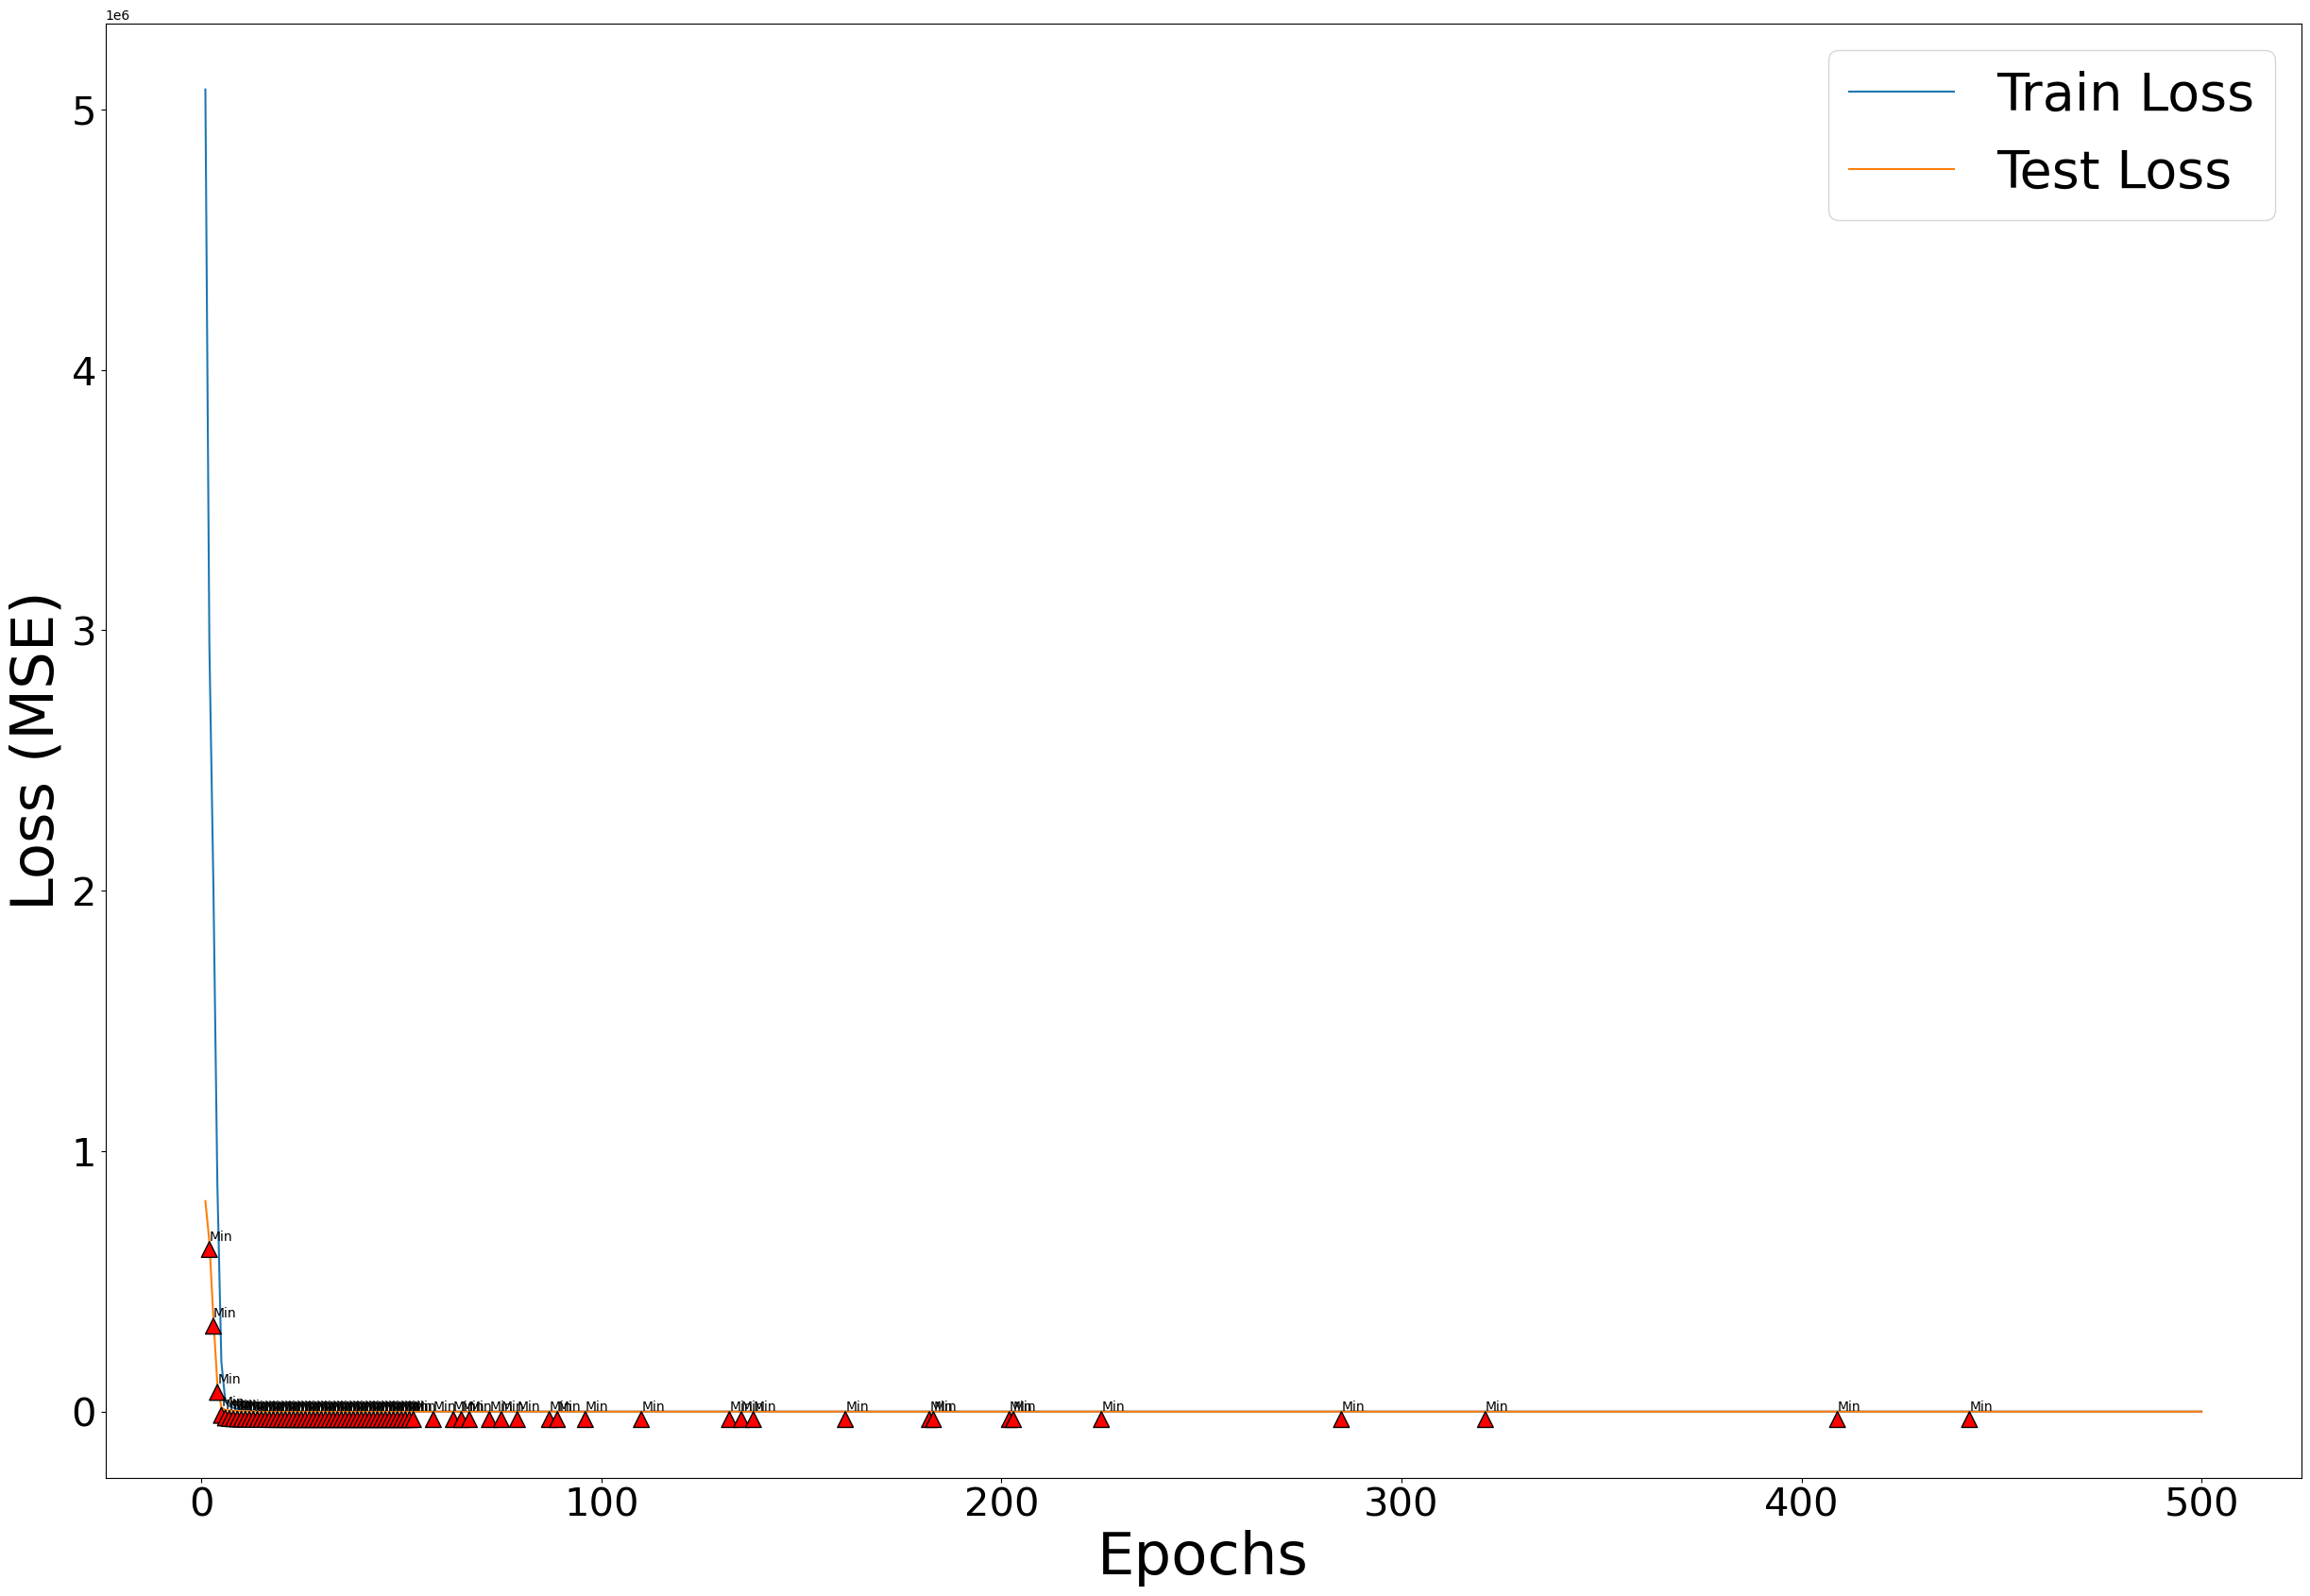

In [121]:
# Plot the data
plt.plot(np.arange(num_epochs)+1, train_losses, label='Train Loss')
plt.plot(np.arange(num_epochs)+1, test_losses, label='Test Loss')

# Track the previous minimum test loss and its index
prev_min_loss = test_losses[0]
prev_min_index = 0

# Annotate each local minimum test loss with arrows
for idx, loss in enumerate(test_losses[1:], start=1):
    if loss < prev_min_loss:
        plt.annotate('Min', xy=(idx+1, loss), xytext=(idx+1, loss + 5000),
                     arrowprops=dict(facecolor='red', shrink=0.05))
        prev_min_loss = loss
        prev_min_index = idx
        
# Add x and y labels
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

# Change axis size
plt.rcParams['axes.labelsize'] = 45  # Change label font size

# Change tick size
plt.tick_params(axis='x', labelsize=30)  # Change tick size for x-axis
plt.tick_params(axis='y', labelsize=30)  # Change tick size for y-axis

# Plot legend, and display figure
plt.legend(fontsize = 40)
plt.show()


# Save Value of Minimum Testing Loss
np.save(ModelName + "MinTrainLoss",prev_min_index)

In [122]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/SavedParamsAndTrainingMetrics')

# Instantiate the best trained model
model_aq = NMR_Model_Aq()

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the saved model parameters
model_aq.load_state_dict(torch.load(save_path))

# Move the model to the GPU 
model_aq.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=39500, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=8, bias=True)
)

In [123]:
## Switch to directory for saving model metrics

os.chdir('/net/clusterhn.cluster.com/home/htjhnson/Desktop/XAI-Uncertainty/ModelPerformanceMetrics')   

In [124]:
## Test model on testing dataset and deterine RMSE

outputs = model_aq(X_train) # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
y_train_cpu = y_train.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, y_train_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "TrainRMSE",err)

model err:  0.0014478845


In [125]:
## Test model on testing dataset and deterine RMSE

model_aq.eval() # Change to evaluation mode (maybe not needed for this model)
outputs = model_aq(X_test) # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
y_test_cpu = y_test.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, y_test_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "TestRMSE",err)

model err:  0.002386487


In [126]:
## Test model on validation dataset and deterine RMSE

model_aq.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model_aq(spectraVal)  # Evaluate input spectra with MLP

# Move tensors to CPU and convert to numpy arrays
outputs_cpu = outputs.detach().cpu().numpy()
concVal_cpu = concVal.detach().cpu().numpy()

err = np.sqrt(mean_squared_error(outputs_cpu, concVal_cpu))  # Determine RMSE
print('model err: ', err)  # Print RMSE

np.save(ModelName + "ValRMSE", err)

model err:  0.0010563846


/tmp/ipykernel_192293/286188780.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model_aq(torch.tensor(spectraVal).float())  # Evaluate input spectra with MLP


In [ ]:
APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ValConc[i]
    Prediction = model_aq(ValSpectra[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)

# Correct the MAPE for the example input with 4 of 8 metabolites present
MAPEs[4] = (APEs[4][0] + APEs[4][1] + APEs[4][4] + APEs[4][6]) / 4

# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))
